# Data Set and the Domain Problem 

This dataset was originally posted on Kaggle. **The key task is to predict whether a product/part will go on backorder.**

Product backorder may be the result of strong sales performance (e.g. the product is in such a high demand that production cannot keep up with sales). However, backorders can upset consumers, lead to canceled orders and decreased customer loyalty. Companies want to avoid backorders, but also avoid overstocking every product (leading to higher inventory costs).

This dataset has ~1.9 million observations of products/parts in an 8 week period. The source of the data is unreferenced.

* __Outcome__: whether the product went on backorder
* __Predictors__: Current inventory, sales history, forecasted sales, recommended stocking amount, product risk flags etc. (22 predictors in total)

The features and the target variable of the dataset are as follows:

**Description**
~~~
# Features: 
sku - Random ID for the product
national_inv - Current inventory level for the part
lead_time - Transit time for product (if available)
in_transit_qty - Amount of product in transit from source
forecast_3_month - Forecast sales for the next 3 months
forecast_6_month - Forecast sales for the next 6 months
forecast_9_month - Forecast sales for the next 9 months
sales_1_month - Sales quantity for the prior 1 month time period
sales_3_month - Sales quantity for the prior 3 month time period
sales_6_month - Sales quantity for the prior 6 month time period
sales_9_month - Sales quantity for the prior 9 month time period
min_bank - Minimum recommend amount to stock
potential_issue - Source issue for part identified
pieces_past_due - Parts overdue from source
perf_6_month_avg - Source performance for prior 6 month period
perf_12_month_avg - Source performance for prior 12 month period
local_bo_qty - Amount of stock orders overdue
deck_risk - Part risk flag
oe_constraint - Part risk flag
ppap_risk - Part risk flag
stop_auto_buy - Part risk flag
rev_stop - Part risk flag

# Target 
went_on_backorder - Product actually went on backorder
~~~

Two data files for training and testing are accessible in the JupyterHub environment.
 
<span style='background:yellow'>**NOTE:** The training data file is 117MB. **Do NOT add any data files to your commits** (training, test, or created), you may blow-through the _push limit_.</span>  
You can easily lock up a notebook with bad coding practices.  
Please save you project early, and often, and use `git commit` to checkpoint your process.



--- 
### Overview / Roadmap

**General steps**:
* Part 1: Preprocessing
  * Dataset carpentry & Exploratory Data Analysis
    * Develop functions to perform the necessary steps, you will have to carpentry the Training and the Testing data.
  * Generate a **smart sample** of the the data
* Part 2: Training and Validation
  * Create 3 alternative pipelines, each does:
      * Anomaly detection
      * Dimensionality reduction
      * Classification
* Part 3: Testing
  * Train chosen model full training data
  * Evaluate model against testing
  * Write a summary of your processing and an analysis of the model performance




---

# Part 1: Data Preprocessing

In this part, we preprocess the given training set. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys
import itertools
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler

## Load dataset

**Description**
~~~
sku - Random ID for the product
national_inv - Current inventory level for the part
lead_time - Transit time for product (if available)
in_transit_qty - Amount of product in transit from source
forecast_3_month - Forecast sales for the next 3 months
forecast_6_month - Forecast sales for the next 6 months
forecast_9_month - Forecast sales for the next 9 months
sales_1_month - Sales quantity for the prior 1 month time period
sales_3_month - Sales quantity for the prior 3 month time period
sales_6_month - Sales quantity for the prior 6 month time period
sales_9_month - Sales quantity for the prior 9 month time period
min_bank - Minimum recommend amount to stock
potential_issue - Source issue for part identified
pieces_past_due - Parts overdue from source
perf_6_month_avg - Source performance for prior 6 month period
perf_12_month_avg - Source performance for prior 12 month period
local_bo_qty - Amount of stock orders overdue
deck_risk - Part risk flag
oe_constraint - Part risk flag
ppap_risk - Part risk flag
stop_auto_buy - Part risk flag
rev_stop - Part risk flag
went_on_backorder - Product actually went on backorder. 
~~~

**NOTE**: This is a real-world dataset without any preprocessing. There will also be warnings due to fact that the 1st column is mixing integer and string values. The last column, `went_on_backorder`, is what we are trying to predict.


In [2]:
# location of the training set; for Parts 1 and 2, 
# you only have access to this training data set for Parts 1 and 2 
DATASET = '/dsa/data/all_datasets/back_order/Kaggle_Training_Dataset_v2.csv'
assert os.path.exists(DATASET)

# Load and shuffle
dataset = pd.read_csv(DATASET).sample(frac = 1).reset_index(drop=True)

dataset.head().transpose()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4
sku,3087333,2914585,1561268,2946534,1329894
national_inv,0.0,13.0,14.0,20.0,17.0
lead_time,9.0,NaN,8.0,2.0,2.0
in_transit_qty,0.0,0.0,0.0,0.0,0.0
forecast_3_month,4.0,0.0,0.0,0.0,0.0
forecast_6_month,7.0,0.0,0.0,0.0,0.0
forecast_9_month,9.0,0.0,0.0,0.0,0.0
sales_1_month,0.0,0.0,0.0,0.0,0.0
sales_3_month,0.0,0.0,0.0,0.0,0.0
sales_6_month,0.0,0.0,0.0,0.0,0.0


In [3]:
#dataset.describe().transpose()

In [4]:
#dataset.nunique()

In [5]:
#dataset.apply(pd.Series.unique)

In [6]:
#dataset.isna().mean()

<AxesSubplot:>

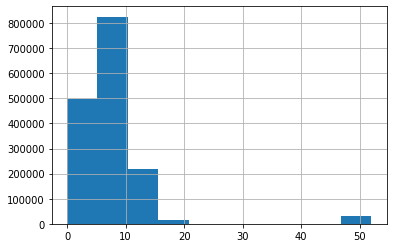

In [7]:
# I notice that we have the -99 for perf_6_month_avg values
# I also know we need to clean up national inv
import matplotlib.pyplot as plt
dataset['lead_time'].hist()
#I ploted this becase I noticed the large jump/outliers. 

In [8]:
print("before shape       :", dataset.shape)

before shape       : (1687861, 23)


---

## Processing

In this section, the goal is to figure out:

* which columns we can use directly,  
* which columns are usable after some processing,  
* and which columns are not processable or obviously irrelevant (like product id) that we will discard.

Then process and prepare this dataset for creating a predictive model.

**You can choose to employ any kind of approach for Exploratory Data Analysis to understand the data better. It is up to you to make the decisions regarding the cleaning/reencoding/dropping/imputing/binning etc.**  The following cells only serve as guidance. 

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687861 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  object 
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1687860 non-null  float64
 15  perf_12_month_avg  1687860 non-n

### Take samples and examine the dataset

In [10]:
#dataset.iloc[:3,:6]

In [11]:
#dataset.iloc[:3,6:12]

In [12]:
#dataset.iloc[:3,12:18]

In [13]:
#dataset.iloc[:3,18:24]

In [14]:
#While sku is not irrelevent, it is not helpful for modeling.
dataset= dataset.drop(columns=['sku'])

### Drop columns that are obviously irrelevant or not processable

In [15]:
# Add code below this comment  (Question #E101)
# ----------------------------------
#Lets not drop rows are are not processable
const = [c for c in dataset if dataset[c].nunique()==1]
print(const)
print('No columns have zero variability')
dataset = dataset.drop(columns=const)
dataset.head()

[]
No columns have zero variability


,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.0,9.0,0.0,4.0,7.0,9.0,0.0,0.0,0.0,0.0,...,0.0,0.70,0.66,0.0,No,No,No,Yes,No,No
1,13.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
2,14.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.97,0.94,0.0,No,No,No,Yes,No,No
3,20.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.97,0.93,0.0,No,No,No,Yes,No,No
4,17.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.98,0.98,0.0,Yes,No,No,Yes,No,No


In [16]:
num = dataset.select_dtypes(include='number').columns #find all cpolumns with numbers
dataset[num] = dataset[num].replace(-99, np.nan)
imp = SimpleImputer(strategy='median')
dataset[num] = imp.fit_transform(dataset[num])
dataset.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.0,9.0,0.0,4.0,7.0,9.0,0.0,0.0,0.0,0.0,...,0.0,0.70,0.66,0.0,No,No,No,Yes,No,No
1,13.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.85,0.83,0.0,Yes,No,No,Yes,No,No
2,14.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.97,0.94,0.0,No,No,No,Yes,No,No
3,20.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.97,0.93,0.0,No,No,No,Yes,No,No
4,17.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.98,0.98,0.0,Yes,No,No,Yes,No,No


### Find unique values of string columns

Now, try to make sure that the Yes/No columns really only contain Yes or No.  
If that's true, proceed to convert them into binaries (0s and 1s).

**Tip**: use [unique()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.unique.html) function of pandas Series.

Example

~~~python
print('went_on_backorder', dataset['went_on_backorder'].unique())
~~~

In [17]:
# All the column names of these yes/no columns
yes_no_columns = list(filter(lambda i: dataset[i].dtype!=np.float64, dataset.columns))
print(yes_no_columns)

# Add code below this comment  (Question #E102)
# ----------------------------------
#I acutally did this above!
dataset.apply(pd.Series.unique)


['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']


national_inv         [1024.0, 3.0, 255.0, 0.0, 8.0, 34.0, 74.0, 25....
lead_time            [4.0, 2.0, 8.0, 0.0, 12.0, 9.0, 52.0, 3.0, 5.0...
in_transit_qty       [28.0, 0.0, 24.0, 23.0, 160.0, 9.0, 13.0, 60.0...
forecast_3_month     [900.0, 0.0, 1.0, 278.0, 25.0, 11.0, 2.0, 18.0...
forecast_6_month     [900.0, 0.0, 12.0, 1.0, 500.0, 50.0, 11.0, 2.0...
forecast_9_month     [900.0, 1.0, 0.0, 24.0, 728.0, 75.0, 11.0, 2.0...
sales_1_month        [88.0, 0.0, 1.0, 7.0, 5.0, 3.0, 138.0, 6.0, 2....
sales_3_month        [312.0, 0.0, 2.0, 14.0, 7.0, 289.0, 20.0, 10.0...
sales_6_month        [625.0, 2.0, 0.0, 29.0, 9.0, 19.0, 540.0, 1.0,...
sales_9_month        [924.0, 2.0, 0.0, 50.0, 14.0, 33.0, 745.0, 3.0...
min_bank             [87.0, 0.0, 2.0, 6.0, 25.0, 50.0, 1.0, 3.0, 5....
potential_issue                                         [No, Yes, nan]
pieces_past_due      [0.0, 37.0, 208.0, 34.0, 3.0, 8.0, 16.0, 31.0,...
perf_6_month_avg     [0.04, 0.91, 0.98, 0.77, 0.73, 0.94, 0.0, 0.83...
perf_1

You may see **nan** also as possible values representing missing values in the dataset.

We fill them using most popular values, the [Mode](https://en.wikipedia.org/wiki/Mode_%28statistics%29) in Stats.

In [18]:
for column_name in yes_no_columns:
    mode = dataset[column_name].apply(str).mode()[0]
    print('Filling missing values of {} with {}'.format(column_name, mode))
    dataset[column_name].fillna(mode, inplace=True)

Filling missing values of potential_issue with No
Filling missing values of deck_risk with No
Filling missing values of oe_constraint with No
Filling missing values of ppap_risk with No
Filling missing values of stop_auto_buy with Yes
Filling missing values of rev_stop with No
Filling missing values of went_on_backorder with No


### Convert yes/no columns into binary (0s and 1s)

In [19]:
# Add code below this comment  (Question #E103)
# ----------------------------------
dataset[yes_no_columns]=dataset[yes_no_columns].apply(lambda s: s.str.strip().str.upper().map({'YES':1,'NO':0}))


Now all columns should be either int64 or float64.

In [20]:

import pandas.api.types as pt

for c in num: # for all of the number columns (defined above)
    if pt.is_float_dtype(dataset[c]):
        v = dataset[c].dropna()
        if np.all(v.mod(1)==0): #if remander exists
            dataset[c] = dataset[c].astype('int32')

In [21]:
dataset.info()
dataset.apply(pd.Series.unique)
# look at our types, we will fix this at the end

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   national_inv       1687861 non-null  int32  
 1   lead_time          1687861 non-null  int32  
 2   in_transit_qty     1687861 non-null  int32  
 3   forecast_3_month   1687861 non-null  int32  
 4   forecast_6_month   1687861 non-null  int32  
 5   forecast_9_month   1687861 non-null  int32  
 6   sales_1_month      1687861 non-null  int32  
 7   sales_3_month      1687861 non-null  int32  
 8   sales_6_month      1687861 non-null  int32  
 9   sales_9_month      1687861 non-null  int32  
 10  min_bank           1687861 non-null  int32  
 11  potential_issue    1687861 non-null  int64  
 12  pieces_past_due    1687861 non-null  int32  
 13  perf_6_month_avg   1687861 non-null  float64
 14  perf_12_month_avg  1687861 non-null  float64
 15  local_bo_qty       1687861 non-n

national_inv         [1024, 3, 255, 0, 8, 34, 74, 25, 7, 17, 9, 231...
lead_time            [4, 2, 8, 0, 12, 9, 52, 3, 5, 10, 16, 15, 6, 1...
in_transit_qty       [28, 0, 24, 23, 160, 9, 13, 60, 58, 1, 2, 35, ...
forecast_3_month     [900, 0, 1, 278, 25, 11, 2, 18, 300, 500, 7, 6...
forecast_6_month     [900, 0, 12, 1, 500, 50, 11, 2, 36, 600, 974, ...
forecast_9_month     [900, 1, 0, 24, 728, 75, 11, 2, 51, 1373, 19, ...
sales_1_month        [88, 0, 1, 7, 5, 3, 138, 6, 2, 78, 52, 19, 76,...
sales_3_month        [312, 0, 2, 14, 7, 289, 20, 10, 1, 15, 122, 3,...
sales_6_month        [625, 2, 0, 29, 9, 19, 540, 1, 33, 32, 4, 28, ...
sales_9_month        [924, 2, 0, 50, 14, 33, 745, 3, 44, 60, 6, 26,...
min_bank             [87, 0, 2, 6, 25, 50, 1, 3, 5, 4, 80, 20, 63, ...
potential_issue                                                 [0, 1]
pieces_past_due      [0, 37, 208, 34, 3, 8, 16, 31, 50, 4, 1, 28, 7...
perf_6_month_avg     [0.04, 0.91, 0.98, 0.77, 0.73, 0.94, 0.0, 0.83...
perf_1

In [22]:
#Lets see how these variables are correlated to our target variable
CorrList = dataset.corr()['went_on_backorder']
SortCorrList = CorrList.drop('went_on_backorder').loc[CorrList.abs() > 0.005] # you can change this variable
SortCorrList = SortCorrList.reindex(SortCorrList.abs().sort_values(ascending=False).index)

print(SortCorrList)

# In short, none of them are individually very correlated individually, but these are the most correlated. 
# These vectors should not be removed.

perf_6_month_avg    -0.028626
perf_12_month_avg   -0.028174
lead_time           -0.018104
potential_issue      0.014090
deck_risk           -0.011691
local_bo_qty         0.009504
ppap_risk            0.008814
Name: went_on_backorder, dtype: float64


### Smartly sample the data into a more manageable size for cross-validation 


This is a good point to re-balance dataset before actually moving on. For sampling, we can either take advantage of pandas/numpy `sample` method or use `imblearn` [package](https://imbalanced-learn.org/stable/user_guide.html#user-guide). 


Create a "smart", balanced sample: 

 * it should be balanced: it is up to you if you do a 50/50 balance or anything else. 
 * it should be manageable-sized: you will run a lot of cross validations in Part 2 that are very time consuming. 
 * it should still reflect the characteristics of the original data.
 
Use any approach you deem necessary to create the balanced sample. It will serve as your data set in the development.  



In [23]:
num_backorder = np.sum(dataset['went_on_backorder']==1)
print('backorder ratio:', num_backorder, '/', len(dataset), '=', num_backorder / len(dataset))

backorder ratio: 11293 / 1687861 = 0.006690716830355106


Create a smart sample of the data and save it.  You can either store the data to csv files or simply use `joblib` to dump the variables and load them in Part 2. 

**Example code for using joblib:**

Say we need to store three objects (sampled_X, sampled_y, model) to a file. 

```python
import joblib

# for dumping 
joblib.dump([sampled_X, sampled_y, model], 'data/sample-data-v1.pkl')

# for loading
sampled_X, sampled_y, model = joblib.load('data/sample-data-v1.pkl')

```


In [24]:
X = dataset.drop('went_on_backorder', axis=1)
y = dataset['went_on_backorder']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=69)


In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1181502 entries, 1305420 to 1506358
Data columns (total 21 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   national_inv       1181502 non-null  int32  
 1   lead_time          1181502 non-null  int32  
 2   in_transit_qty     1181502 non-null  int32  
 3   forecast_3_month   1181502 non-null  int32  
 4   forecast_6_month   1181502 non-null  int32  
 5   forecast_9_month   1181502 non-null  int32  
 6   sales_1_month      1181502 non-null  int32  
 7   sales_3_month      1181502 non-null  int32  
 8   sales_6_month      1181502 non-null  int32  
 9   sales_9_month      1181502 non-null  int32  
 10  min_bank           1181502 non-null  int32  
 11  potential_issue    1181502 non-null  int64  
 12  pieces_past_due    1181502 non-null  int32  
 13  perf_6_month_avg   1181502 non-null  float64
 14  perf_12_month_avg  1181502 non-null  float64
 15  local_bo_qty       1181502

In [26]:
# I am unable to get SMOTE to work with my memory requirements. This also means that I will be unable to make oversampleing work
#from imblearn.over_sampling import SMOTE
#sm = SMOTE()
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [27]:
#therefore I am using undersampling 
from sklearn.utils import resample
df_tr = pd.concat([X_train, y_train], axis=1)
maj = df_tr[df_tr.went_on_backorder == 0]
min_ = df_tr[df_tr.went_on_backorder == 1]

In [28]:
maj_down = resample(maj,
                    replace=False,
                    n_samples=len(min_),
                    random_state=27)

In [29]:
df_down = pd.concat([maj_down, min_]) \
             .sample(frac=1, random_state=42) \
             .reset_index(drop=True)
# check balance
print(df_down.went_on_backorder.value_counts())

0    7912
1    7912
Name: went_on_backorder, dtype: int64


In [30]:
X_train = df_down.drop('went_on_backorder', axis=1)
y_train = df_down.went_on_backorder

In [31]:
#df_bal.info()

print(f'Before undersample: {y_test.sum()/y_test.count()}')
print(f'After undersample: {y_train.sum()/y_train.count()}')


Before undersample: 0.006677080885300745
After undersample: 0.5



**Note:** After sampling the data, you may want to write the data to a file for reloading later.

<span style="background: yellow;">If required, remove the `dataset` variable to avoid any memory-related issue.</span> 

In [32]:
# Write your smart, balanced sample to local file  
# ----------------------------------
import joblib
joblib.dump([X_train, y_train], 'training-data.pkl')
joblib.dump([X_test, y_test], 'testing-data.pkl')

# I am not pickling a model yet, I thought this was to be done in part two!

['testing-data.pkl']


**Make commits often and definitely when done!**  
Comment should be: `Final Project, Checkpoint - Data Sampled`


# Save your notebook!
## Then commit and push 